# ANN Phase-2
#### Aiza Ali (22i-0612) | Malaika Saleem (22i-0509)

## Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets

## Methodologies On CIFAR-10

In [3]:
transform=transforms.ToTensor()
dataset=datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
loader=DataLoader(dataset,batch_size=100,shuffle=False,num_workers=2)

mean=0.
std=0.
nb_samples=0.

for data in loader:
    images,_=data
    batch_samples=images.size(0)
    images=images.view(batch_samples,images.size(1),-1)
    mean+=images.mean(2).sum(0)
    std+=images.std(2).sum(0)
    nb_samples+=batch_samples

mean/=nb_samples
std/=nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')


100%|██████████| 170M/170M [00:02<00:00, 57.3MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2023, 0.1994, 0.2010])


### Baseline (As Proposed by the Paper)

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
test_dataset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN,self).__init__()
        self.conv_block1=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block2=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block3=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc1=nn.Linear(256*4*4,512)
        self.dropout_fc=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,10)

    def forward(self,x):
        x=self.conv_block1(x)
        x=self.conv_block2(x)
        x=self.conv_block3(x)
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.dropout_fc(x)
        x=self.fc2(x)
        return x

model=EnhancedCNN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss=0.0
        correct=0
        total=0

        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()*labels.size(0)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()

        train_acc=100.*correct/total
        avg_loss=running_loss/total
        print(f"Epoch [{epoch+1}/20] - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")
        evaluate()

def evaluate():
    model.eval()
    correct=0
    total=0

    with torch.no_grad():
        for images,labels in test_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()

    acc=100.*correct/total
    print(f"Test Accuracy: {acc:.2f}%\n")

train(num_epochs=20)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20] - Loss: 1.8135, Train Acc: 31.62%
Test Accuracy: 48.07%

Epoch [2/20] - Loss: 1.4055, Train Acc: 48.65%
Test Accuracy: 58.80%

Epoch [3/20] - Loss: 1.1938, Train Acc: 57.96%
Test Accuracy: 63.08%

Epoch [4/20] - Loss: 1.0528, Train Acc: 63.51%
Test Accuracy: 68.24%

Epoch [5/20] - Loss: 0.9641, Train Acc: 66.52%
Test Accuracy: 70.74%

Epoch [6/20] - Loss: 0.8932, Train Acc: 69.74%
Test Accuracy: 75.82%

Epoch [7/20] - Loss: 0.8275, Train Acc: 72.30%
Test Accuracy: 78.60%

Epoch [8/20] - Loss: 0.7691, Train Acc: 74.48%
Test Accuracy: 78.66%

Epoch [9/20] - Loss: 0.7157, Train Acc: 76.29%
Test Accuracy: 78.34%

Epoch [10/20] - Loss: 0.6672, Train Acc: 78.12%
Test Accuracy: 82.19%

Epoch [11/20] - Loss: 0.6308, Train Acc: 79.46%
Test Accuracy: 82.39%

Epoch [12/20] - Loss: 0.5981, Train Acc: 80.49%
Test Accuracy: 83.60%

Epoch [13/20] - Loss: 0.5710, Train Acc: 81.41%
Test Accuracy: 84.28%

Epoch [14/

### Additional Blocks Added
Summary of Improvements:
- Deeper CNN (5 conv blocks)

- BatchNorm, Dropout, ReLU after every conv

- MaxPooling after each block

- SGD with momentum + weight decay

- Learning rate scheduler


#### Load Data

In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])
transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

trainset=datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)
testset=datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
trainloader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
testloader=DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Epoch 1/20 | Loss: 2.0437 | Train Acc: 17.72% | Test Acc: 19.34%
Epoch 2/20 | Loss: 1.8581 | Train Acc: 24.77% | Test Acc: 33.19%
Epoch 3/20 | Loss: 1.5652 | Train Acc: 38.79% | Test Acc: 41.37%
Epoch 4/20 | Loss: 1.3129 | Train Acc: 50.05% | Test Acc: 50.21%
Epoch 5/20 | Loss: 1.1344 | Train Acc: 59.01% | Test Acc: 63.67%
Epoch 6/20 | Loss: 0.9842 | Train Acc: 66.80% | Test Acc: 67.40%
Epoch 7/20 | Loss: 0.8933 | Train Acc: 70.23% | Test Acc: 72.58%
Epoch 8/20 | Loss: 0.8193 | Train Acc: 73.29% | Test Acc: 73.36%
Epoch 9/20 | Loss: 0.7778 | Train Acc: 74.63% | Test Acc: 74.30%
Epoch 10/20 | Loss: 0.7453 | Train Acc: 75.91% | Test Acc: 67.80%
Epoch 11/20 | Loss: 0.7207 | Train Acc: 76.31% | Test Acc: 75.11%
Epoch 12/20 | Loss: 0.7020 | Train Acc: 77.24% | Test Acc: 73.74%
Epoch 13/20 | Loss: 0.6904 | Train Acc: 77.68% | Test Acc: 75.41%
Epoch 14/20 | Loss: 0.6648 | Train Acc: 78.49% | Test Acc: 79.31%
Epoch 15/20 | Loss: 0.6618 | Train Acc: 78.71% | Test Acc: 67.90%
Epoch 16/20 | Loss:

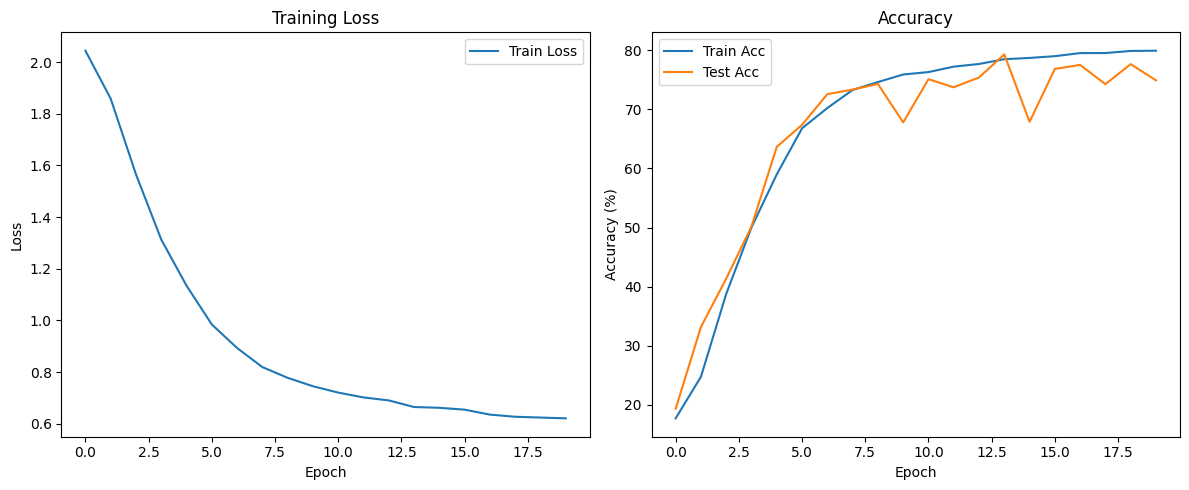

In [6]:
trainloader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
testloader=DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN,self).__init__()
        self.conv_block1=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block2=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block3=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block4=nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block5=nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc1=nn.Linear(512*1*1,512)
        self.dropout_fc=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,10)

    def forward(self,x):
        x=self.conv_block1(x)
        x=self.conv_block2(x)
        x=self.conv_block3(x)
        x=self.conv_block4(x)
        x=self.conv_block5(x)
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.dropout_fc(x)
        x=self.fc2(x)
        return x

model=EnhancedCNN().to(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9,weight_decay=5e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)

train_losses_5block_10=[]
train_accuracies_5block_10=[]
test_accuracies_5block_10=[]

def test_model():
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for inputs,targets in testloader:
            inputs,targets=inputs.to(device),targets.to(device)
            outputs=model(inputs)
            _,predicted=outputs.max(1)
            total+=targets.size(0)
            correct+=predicted.eq(targets).sum().item()
    return 100.*correct/total

def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss,correct,total=0.0,0,0
        for inputs,targets in trainloader:
            inputs,targets=inputs.to(device),targets.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,targets)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()*inputs.size(0)
            _,predicted=outputs.max(1)
            total+=targets.size(0)
            correct+=predicted.eq(targets).sum().item()

        scheduler.step()
        train_acc=100.*correct/total
        test_acc=test_model()
        train_losses_5block_10.append(running_loss/total)
        train_accuracies_5block_10.append(train_acc)
        test_accuracies_5block_10.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/total:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

train_model(num_epochs=20)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses_5block_10,label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies_5block_10,label='Train Acc')
plt.plot(test_accuracies_5block_10,label='Test Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


### Introducing GCN

Epoch [1/20] Train Loss: 1.7068, Train Acc: 33.00%
Test Accuracy: 46.76%, Test Loss: 1.3987
Epoch [2/20] Train Loss: 1.2970, Train Acc: 52.48%
Test Accuracy: 56.37%, Test Loss: 1.2054
Epoch [3/20] Train Loss: 1.0732, Train Acc: 62.26%
Test Accuracy: 62.59%, Test Loss: 1.1064
Epoch [4/20] Train Loss: 0.9245, Train Acc: 68.01%
Test Accuracy: 71.98%, Test Loss: 0.8019
Epoch [5/20] Train Loss: 0.8230, Train Acc: 71.86%
Test Accuracy: 77.25%, Test Loss: 0.6575
Epoch [6/20] Train Loss: 0.7431, Train Acc: 75.18%
Test Accuracy: 78.16%, Test Loss: 0.6517
Epoch [7/20] Train Loss: 0.6733, Train Acc: 77.37%
Test Accuracy: 79.34%, Test Loss: 0.6253
Epoch [8/20] Train Loss: 0.6246, Train Acc: 79.26%
Test Accuracy: 81.98%, Test Loss: 0.5389
Epoch [9/20] Train Loss: 0.5863, Train Acc: 80.69%
Test Accuracy: 83.84%, Test Loss: 0.4811
Epoch [10/20] Train Loss: 0.5524, Train Acc: 81.75%
Test Accuracy: 83.74%, Test Loss: 0.4960
Epoch [11/20] Train Loss: 0.5191, Train Acc: 82.99%
Test Accuracy: 85.00%, Test

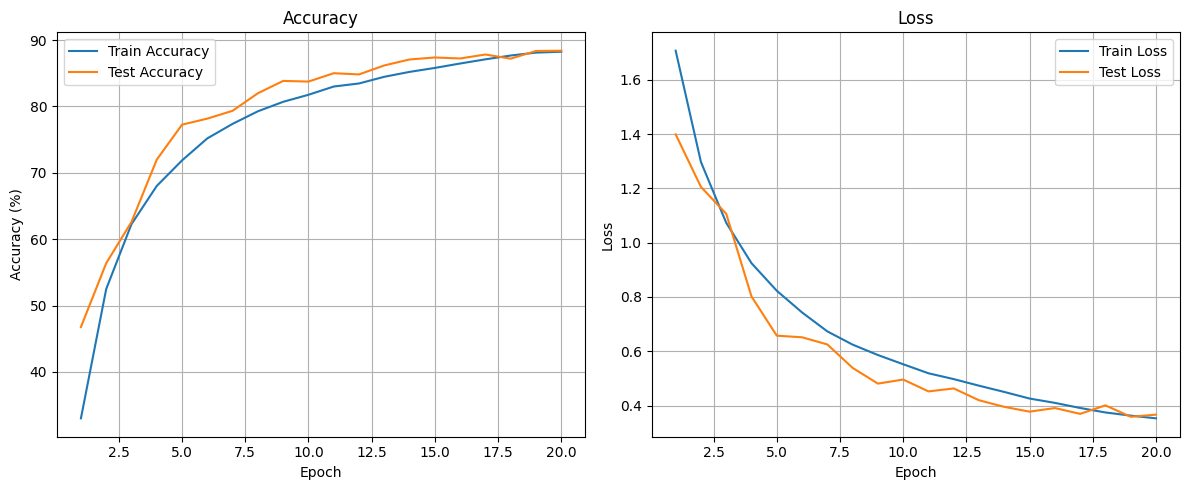

In [7]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

class SimpleGCNLayer(nn.Module):
    def __init__(self,in_features,out_features):
        super(SimpleGCNLayer,self).__init__()
        self.linear=nn.Linear(in_features,out_features)

    def forward(self,x):
        A=torch.eye(x.size(1),device=x.device)
        A_hat=A+torch.eye(x.size(1),device=x.device)
        D_hat=torch.diag(A_hat.sum(1))
        D_hat_inv_sqrt=torch.inverse(torch.sqrt(D_hat))
        norm_A=D_hat_inv_sqrt@A_hat@D_hat_inv_sqrt
        x=torch.matmul(x,norm_A)
        return self.linear(x)

class CNN_GCN_Model(nn.Module):
    def __init__(self):
        super(CNN_GCN_Model,self).__init__()
        self.block1=self._conv_block(3,64)
        self.block2=self._conv_block(64,128)
        self.block3=self._conv_block(128,256)
        self.block4=self._conv_block(256,512)
        self.block5=self._conv_block(512,512)
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(512*1*1,256)
        self.gcn=SimpleGCNLayer(256,128)
        self.dropout=nn.Dropout(0.5)
        self.fc2=nn.Linear(128,10)

    def _conv_block(self,in_c,out_c):
        return nn.Sequential(
            nn.Conv2d(in_c,out_c,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c,out_c,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        x=self.flatten(x)
        x=F.relu(self.fc1(x))
        x=self.gcn(x)
        x=self.dropout(x)
        x=self.fc2(x)
        return x

model=CNN_GCN_Model().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

train_losses_gcn_10,test_losses_gcn_10=[],[]
train_accuracies_gcn_10,test_accuracies_gcn_10=[],[]

def evaluate():
    model.eval()
    correct,total,loss_total=0,0,0
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss_total+=loss.item()*labels.size(0)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
    acc=100*correct/total
    avg_loss=loss_total/total
    test_accuracies_gcn_10.append(acc)
    test_losses_gcn_10.append(avg_loss)
    print(f"Test Accuracy: {acc:.2f}%, Test Loss: {avg_loss:.4f}")

def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        correct,total,loss_total=0,0,0
        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_total+=loss.item()*labels.size(0)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
        train_acc=100*correct/total
        train_loss=loss_total/total
        train_accuracies_gcn_10.append(train_acc)
        train_losses_gcn_10.append(train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        evaluate()

train(num_epochs=20)

epochs=range(1,len(train_losses_gcn_10)+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs,train_accuracies_gcn_10,label='Train Accuracy')
plt.plot(epochs,test_accuracies_gcn_10,label='Test Accuracy')
plt.xlabel('Epoch');plt.ylabel('Accuracy (%)');plt.title('Accuracy')
plt.legend();plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs,train_losses_gcn_10,label='Train Loss')
plt.plot(epochs,test_losses_gcn_10,label='Test Loss')
plt.xlabel('Epoch');plt.ylabel('Loss');plt.title('Loss')
plt.legend();plt.grid(True)

plt.tight_layout()
plt.show()


### CNN + Squeeze Excitation + Residual Connections

Epoch 1/20 | Loss: 1.8935 | Train Acc: 27.86% | Test Acc: 34.21%
Epoch 2/20 | Loss: 1.4459 | Train Acc: 47.35% | Test Acc: 59.02%
Epoch 3/20 | Loss: 1.2132 | Train Acc: 57.67% | Test Acc: 60.10%
Epoch 4/20 | Loss: 1.0533 | Train Acc: 64.19% | Test Acc: 60.94%
Epoch 5/20 | Loss: 0.9419 | Train Acc: 68.21% | Test Acc: 67.76%
Epoch 6/20 | Loss: 0.8666 | Train Acc: 71.16% | Test Acc: 73.03%
Epoch 7/20 | Loss: 0.8235 | Train Acc: 72.71% | Test Acc: 73.32%
Epoch 8/20 | Loss: 0.7843 | Train Acc: 73.88% | Test Acc: 75.23%
Epoch 9/20 | Loss: 0.7678 | Train Acc: 74.50% | Test Acc: 72.89%
Epoch 10/20 | Loss: 0.7486 | Train Acc: 74.92% | Test Acc: 77.14%
Epoch 11/20 | Loss: 0.7261 | Train Acc: 75.95% | Test Acc: 74.54%
Epoch 12/20 | Loss: 0.7196 | Train Acc: 76.08% | Test Acc: 76.16%
Epoch 13/20 | Loss: 0.7142 | Train Acc: 76.39% | Test Acc: 78.18%
Epoch 14/20 | Loss: 0.6998 | Train Acc: 76.88% | Test Acc: 79.90%
Epoch 15/20 | Loss: 0.6857 | Train Acc: 77.18% | Test Acc: 76.04%
Epoch 16/20 | Loss:

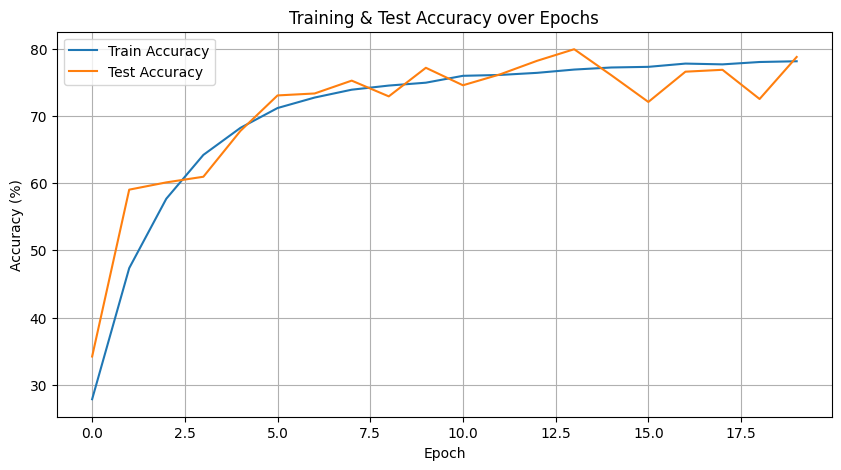

In [8]:
trainloader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
testloader=DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)

class SEBlock(nn.Module):
    def __init__(self,channel,reduction=16):
        super(SEBlock,self).__init__()
        self.fc1=nn.Linear(channel,channel//reduction)
        self.fc2=nn.Linear(channel//reduction,channel)

    def forward(self,x):
        b,c,_,_=x.size()
        y=F.adaptive_avg_pool2d(x,1).view(b,c)
        y=F.relu(self.fc1(y))
        y=torch.sigmoid(self.fc2(y)).view(b,c,1,1)
        return x*y

class ResidualSEBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(ResidualSEBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU()
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.se=SEBlock(out_channels)
        self.residual_conv=nn.Conv2d(in_channels,out_channels,kernel_size=1) if in_channels!=out_channels else nn.Identity()
        self.pool=nn.MaxPool2d(2)
        self.dropout=nn.Dropout(0.25)

    def forward(self,x):
        identity=self.residual_conv(x)
        out=self.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out=self.se(out)
        out+=identity
        out=self.relu(out)
        out=self.pool(out)
        out=self.dropout(out)
        return out

class SE_Residual_CNN(nn.Module):
    def __init__(self):
        super(SE_Residual_CNN,self).__init__()
        self.block1=ResidualSEBlock(3,64)
        self.block2=ResidualSEBlock(64,128)
        self.block3=ResidualSEBlock(128,256)
        self.block4=ResidualSEBlock(256,512)
        self.block5=ResidualSEBlock(512,512)
        self.fc1=nn.Linear(512,512)
        self.dropout=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,10)

    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        x=F.adaptive_avg_pool2d(x,1).view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        return self.fc2(x)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=SE_Residual_CNN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9,weight_decay=5e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)

train_accuracies_se_10=[]
test_accuracies_se_10=[]

def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        correct,total,loss_sum=0,0,0
        for x,y in trainloader:
            x,y=x.to(device),y.to(device)
            optimizer.zero_grad()
            out=model(x)
            loss=criterion(out,y)
            loss.backward()
            optimizer.step()
            loss_sum+=loss.item()*x.size(0)
            _,preds=out.max(1)
            correct+=preds.eq(y).sum().item()
            total+=y.size(0)
        train_acc=100.*correct/total
        test_acc=test_model()
        train_accuracies_se_10.append(train_acc)
        test_accuracies_se_10.append(test_acc)
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss_sum/total:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

def test_model():
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for x,y in testloader:
            x,y=x.to(device),y.to(device)
            out=model(x)
            _,preds=out.max(1)
            correct+=preds.eq(y).sum().item()
            total+=y.size(0)
    return 100.*correct/total

train_model(num_epochs=20)

plt.figure(figsize=(10,5))
plt.plot(train_accuracies_se_10,label='Train Accuracy')
plt.plot(test_accuracies_se_10,label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### CNN + Residual Attention + Attention Modules



Epoch 1/20 | Loss: 2.6953 | Train Acc: 14.71% | Test Acc: 21.54%
Epoch 2/20 | Loss: 1.8296 | Train Acc: 29.61% | Test Acc: 36.70%
Epoch 3/20 | Loss: 1.5662 | Train Acc: 41.02% | Test Acc: 45.89%
Epoch 4/20 | Loss: 1.3737 | Train Acc: 49.28% | Test Acc: 49.87%
Epoch 5/20 | Loss: 1.1715 | Train Acc: 57.43% | Test Acc: 57.07%
Epoch 6/20 | Loss: 0.9943 | Train Acc: 64.63% | Test Acc: 67.48%
Epoch 7/20 | Loss: 0.8793 | Train Acc: 69.24% | Test Acc: 65.81%
Epoch 8/20 | Loss: 0.8068 | Train Acc: 71.97% | Test Acc: 71.95%
Epoch 9/20 | Loss: 0.7564 | Train Acc: 73.91% | Test Acc: 72.07%
Epoch 10/20 | Loss: 0.7133 | Train Acc: 75.66% | Test Acc: 62.74%
Epoch 11/20 | Loss: 0.6838 | Train Acc: 76.52% | Test Acc: 72.59%
Epoch 12/20 | Loss: 0.6593 | Train Acc: 77.43% | Test Acc: 73.10%
Epoch 13/20 | Loss: 0.6356 | Train Acc: 78.42% | Test Acc: 72.91%
Epoch 14/20 | Loss: 0.6217 | Train Acc: 78.89% | Test Acc: 69.94%
Epoch 15/20 | Loss: 0.5994 | Train Acc: 79.64% | Test Acc: 72.16%
Epoch 16/20 | Loss:

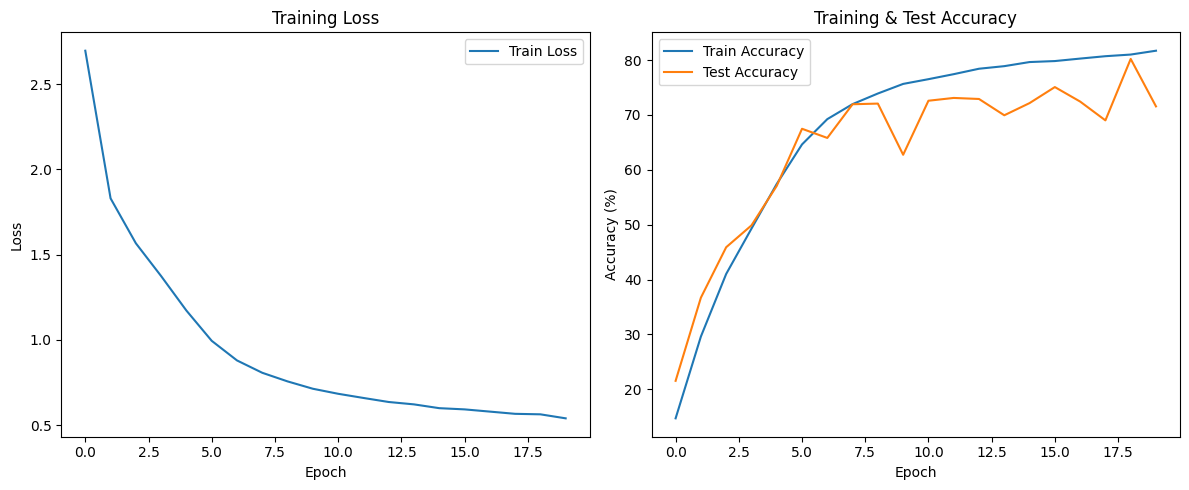

In [9]:
trainloader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
testloader=DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)

class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super(ResidualBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.downsample=None
        if stride!=1 or in_channels!=out_channels:
            self.downsample=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self,x):
        identity=x
        out=self.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        if self.downsample:
            identity=self.downsample(x)
        out+=identity
        out=self.relu(out)
        return out

class AttentionModule(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(AttentionModule,self).__init__()
        self.trunk_branch=nn.Sequential(
            ResidualBlock(in_channels,out_channels),
            ResidualBlock(out_channels,out_channels)
        )
        self.softmax_branch=nn.Sequential(
            nn.MaxPool2d(3,stride=2,padding=1),
            ResidualBlock(in_channels,out_channels),
            nn.MaxPool2d(3,stride=2,padding=1),
            ResidualBlock(out_channels,out_channels),
            nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True),
            ResidualBlock(out_channels,out_channels),
            nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True),
            nn.Sigmoid()
        )

    def forward(self,x):
        trunk=self.trunk_branch(x)
        mask=self.softmax_branch(x)
        out=trunk*mask+trunk
        return out

class ResidualAttentionModel(nn.Module):
    def __init__(self):
        super(ResidualAttentionModel,self).__init__()
        self.pre_layers=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.residual_block1=ResidualBlock(64,128,stride=2)
        self.attention_module1=AttentionModule(128,128)
        self.residual_block2=ResidualBlock(128,256,stride=2)
        self.attention_module2=AttentionModule(256,256)
        self.residual_block3=ResidualBlock(256,512,stride=2)
        self.attention_module3=AttentionModule(512,512)
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512,10)

    def forward(self,x):
        out=self.pre_layers(x)
        out=self.residual_block1(out)
        out=self.attention_module1(out)
        out=self.residual_block2(out)
        out=self.attention_module2(out)
        out=self.residual_block3(out)
        out=self.attention_module3(out)
        out=self.avg_pool(out)
        out=out.view(out.size(0),-1)
        out=self.fc(out)
        return out

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=ResidualAttentionModel().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9,weight_decay=5e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)

train_losses_atten_10=[]
train_accuracies_atten_10=[]
test_accuracies_atten_10=[]

def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss,correct,total=0.0,0,0
        for inputs,targets in trainloader:
            inputs,targets=inputs.to(device),targets.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,targets)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()*inputs.size(0)
            _,preds=torch.max(outputs,1)
            correct+=preds.eq(targets).sum().item()
            total+=targets.size(0)
        train_acc=100.*correct/total
        test_acc=test_model()
        train_losses_atten_10.append(total_loss/total)
        train_accuracies_atten_10.append(train_acc)
        test_accuracies_atten_10.append(test_acc)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/total:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        scheduler.step()

def test_model():
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for inputs,targets in testloader:
            inputs,targets=inputs.to(device),targets.to(device)
            outputs=model(inputs)
            _,predicted=torch.max(outputs,1)
            correct+=predicted.eq(targets).sum().item()
            total+=targets.size(0)
    return 100.*correct/total

train_model(num_epochs=20)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses_atten_10,label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accuracies_atten_10,label='Train Accuracy')
plt.plot(test_accuracies_atten_10,label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


## Analysis for CIFAR-10

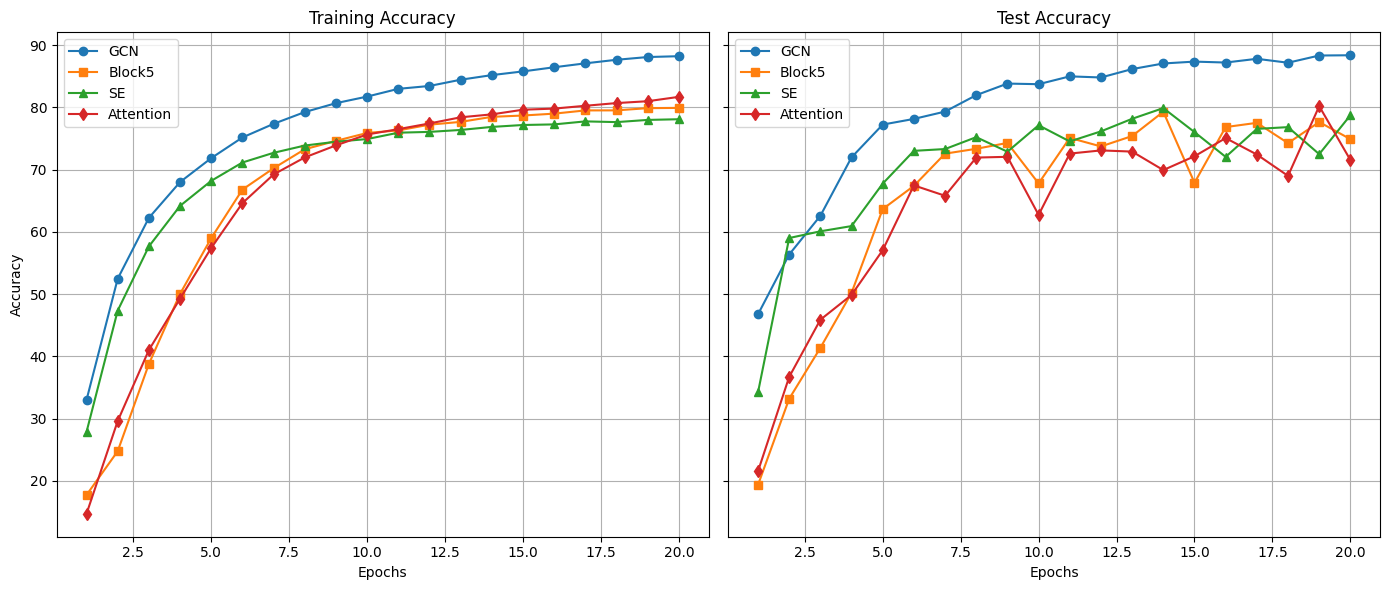

In [10]:
import matplotlib.pyplot as plt

fig,axes=plt.subplots(1,2,figsize=(14,6),sharey=True)

axes[0].plot(epochs,train_accuracies_gcn_10,label='GCN',marker='o')
axes[0].plot(epochs,train_accuracies_5block_10,label='Block5',marker='s')
axes[0].plot(epochs,train_accuracies_se_10,label='SE',marker='^')
axes[0].plot(epochs,train_accuracies_atten_10,label='Attention',marker='d')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(epochs,test_accuracies_gcn_10,label='GCN',marker='o')
axes[1].plot(epochs,test_accuracies_5block_10,label='Block5',marker='s')
axes[1].plot(epochs,test_accuracies_se_10,label='SE',marker='^')
axes[1].plot(epochs,test_accuracies_atten_10,label='Attention',marker='d')
axes[1].set_title('Test Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


### Thus we can conclude that for Cifar-10 GCN performed the best


## Methodologies On CIFAR-100

In [11]:
transform = transforms.ToTensor()
dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=100, shuffle=False, num_workers=2)

mean = 0.
std = 0.
nb_samples = 0.

for data in loader:
    images, _ = data
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')


100%|██████████| 169M/169M [00:02<00:00, 79.4MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Mean: tensor([0.5071, 0.4865, 0.4409])
Std: tensor([0.2009, 0.1984, 0.2023])


#### Load Data

In [12]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

train_dataset=torchvision.datasets.CIFAR100(root='./data',train=True,download=True,transform=transform_train)
test_dataset=torchvision.datasets.CIFAR100(root='./data',train=False,download=True,transform=transform_test)

train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Baseline (As Proposed by the Paper)

Epoch [1/100] - Loss: 4.3497, Train Acc: 3.29%
Test Accuracy: 6.88%, Test Loss: 4.0102

Epoch [2/100] - Loss: 4.1473, Train Acc: 4.67%
Test Accuracy: 8.24%, Test Loss: 3.8676

Epoch [3/100] - Loss: 4.0638, Train Acc: 5.54%
Test Accuracy: 9.68%, Test Loss: 3.7502

Epoch [4/100] - Loss: 3.9797, Train Acc: 6.64%
Test Accuracy: 12.54%, Test Loss: 3.6266

Epoch [5/100] - Loss: 3.8768, Train Acc: 7.45%
Test Accuracy: 13.58%, Test Loss: 3.4952

Epoch [6/100] - Loss: 3.7748, Train Acc: 8.64%
Test Accuracy: 15.95%, Test Loss: 3.3711

Epoch [7/100] - Loss: 3.6683, Train Acc: 10.00%
Test Accuracy: 18.45%, Test Loss: 3.1831

Epoch [8/100] - Loss: 3.5089, Train Acc: 13.04%
Test Accuracy: 23.88%, Test Loss: 2.9391

Epoch [9/100] - Loss: 3.3176, Train Acc: 16.51%
Test Accuracy: 27.29%, Test Loss: 2.7491

Epoch [10/100] - Loss: 3.1535, Train Acc: 19.56%
Test Accuracy: 30.33%, Test Loss: 2.6591

Epoch [11/100] - Loss: 2.9925, Train Acc: 22.74%
Test Accuracy: 31.75%, Test Loss: 2.5888

Epoch [12/100] - 

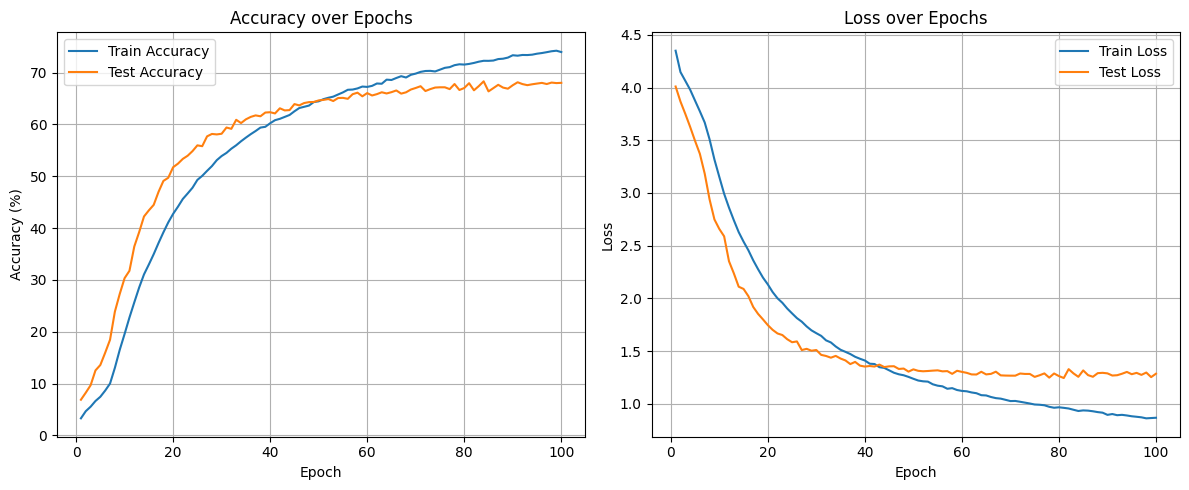

In [13]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN,self).__init__()
        self.conv_block1=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block2=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.conv_block3=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc1=nn.Linear(256*4*4,512)
        self.dropout_fc=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,100)

    def forward(self,x):
        x=self.conv_block1(x)
        x=self.conv_block2(x)
        x=self.conv_block3(x)
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.dropout_fc(x)
        x=self.fc2(x)
        return x

model=EnhancedCNN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

train_losses=[]
test_losses=[]
train_accuracies=[]
test_accuracies=[]

def evaluate():
    model.eval()
    correct=0
    total=0
    running_loss=0.0
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            running_loss+=loss.item()*labels.size(0)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
    avg_loss=running_loss/total
    acc=100.*correct/total
    test_losses.append(avg_loss)
    test_accuracies.append(acc)
    print(f"Test Accuracy: {acc:.2f}%, Test Loss: {avg_loss:.4f}\n")

def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss=0.0
        correct=0
        total=0
        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()*labels.size(0)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
        train_acc=100.*correct/total
        avg_loss=running_loss/total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")
        evaluate()

train(num_epochs=100)

epochs=range(1,len(train_losses)+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs,train_accuracies,label='Train Accuracy')
plt.plot(epochs,test_accuracies,label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs,train_losses,label='Train Loss')
plt.plot(epochs,test_losses,label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Additional Blocks Added
Summary of Improvements:
- Deeper CNN (5 conv blocks)

- BatchNorm, Dropout, ReLU after every conv

- MaxPooling after each block

- SGD with momentum + weight decay

- Learning rate scheduler

- 100 training epochs

Epoch 1/100 | Loss: 2.3092 | Train Acc: 15.94% | Test Acc: 26.44%
Epoch 2/100 | Loss: 1.8849 | Train Acc: 26.38% | Test Acc: 27.16%
Epoch 3/100 | Loss: 1.5737 | Train Acc: 40.78% | Test Acc: 47.91%
Epoch 4/100 | Loss: 1.2952 | Train Acc: 54.67% | Test Acc: 53.13%
Epoch 5/100 | Loss: 1.0813 | Train Acc: 63.18% | Test Acc: 63.77%
Epoch 6/100 | Loss: 0.9797 | Train Acc: 67.69% | Test Acc: 64.53%
Epoch 7/100 | Loss: 0.8852 | Train Acc: 71.08% | Test Acc: 68.18%
Epoch 8/100 | Loss: 0.8286 | Train Acc: 73.32% | Test Acc: 64.38%
Epoch 9/100 | Loss: 0.7921 | Train Acc: 74.80% | Test Acc: 71.87%
Epoch 10/100 | Loss: 0.7602 | Train Acc: 75.68% | Test Acc: 74.08%
Epoch 11/100 | Loss: 0.7354 | Train Acc: 76.32% | Test Acc: 71.89%
Epoch 12/100 | Loss: 0.7229 | Train Acc: 76.87% | Test Acc: 77.35%
Epoch 13/100 | Loss: 0.7073 | Train Acc: 77.20% | Test Acc: 73.69%
Epoch 14/100 | Loss: 0.6860 | Train Acc: 77.73% | Test Acc: 76.97%
Epoch 15/100 | Loss: 0.6799 | Train Acc: 78.05% | Test Acc: 72.83%
Epoc

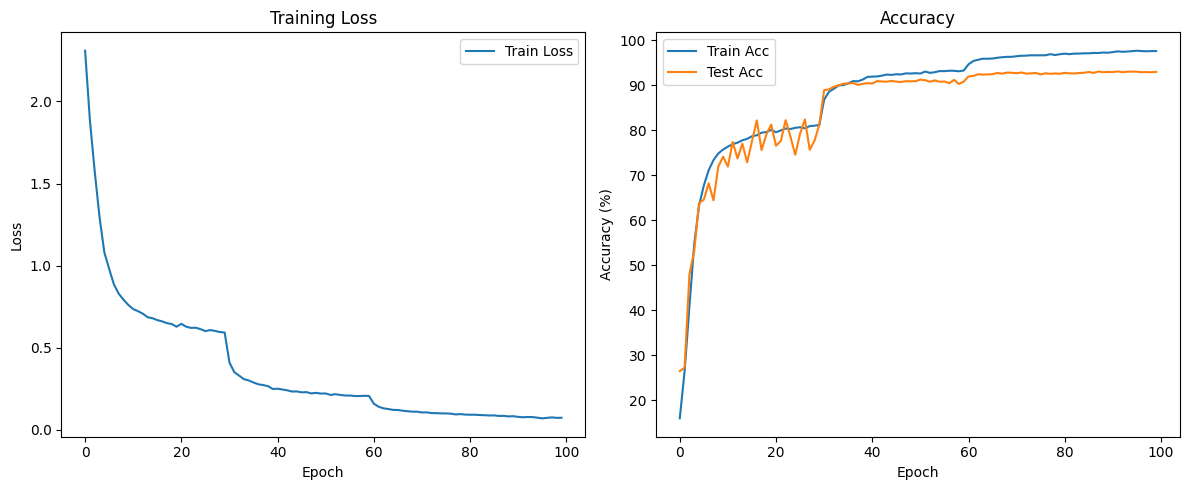

In [14]:
trainloader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
testloader=DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN,self).__init__()
        def conv_block(in_ch,out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(),
                nn.Conv2d(out_ch,out_ch,kernel_size=3,padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(0.25)
            )
        self.conv_block1=conv_block(3,64)
        self.conv_block2=conv_block(64,128)
        self.conv_block3=conv_block(128,256)
        self.conv_block4=conv_block(256,512)
        self.conv_block5=conv_block(512,512)
        self.fc1=nn.Linear(512,512)
        self.dropout_fc=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,100)
    def forward(self,x):
        x=self.conv_block1(x)
        x=self.conv_block2(x)
        x=self.conv_block3(x)
        x=self.conv_block4(x)
        x=self.conv_block5(x)
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=self.dropout_fc(x)
        x=self.fc2(x)
        return x

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=EnhancedCNN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9,weight_decay=5e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)

train_losses_5block=[]
train_accuracies_5block=[]
test_accuracies_5block=[]

def test_model():
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for inputs,targets in testloader:
            inputs,targets=inputs.to(device),targets.to(device)
            outputs=model(inputs)
            _,predicted=outputs.max(1)
            total+=targets.size(0)
            correct+=predicted.eq(targets).sum().item()
    return 100.*correct/total

def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss,correct,total=0.0,0,0
        for inputs,targets in trainloader:
            inputs,targets=inputs.to(device),targets.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,targets)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()*inputs.size(0)
            _,predicted=outputs.max(1)
            total+=targets.size(0)
            correct+=predicted.eq(targets).sum().item()
        scheduler.step()
        train_acc=100.*correct/total
        test_acc=test_model()
        train_losses_5block.append(running_loss/total)
        train_accuracies_5block.append(train_acc)
        test_accuracies_5block.append(test_acc)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/total:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

train_model(num_epochs=100)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses_5block,label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accuracies_5block,label='Train Acc')
plt.plot(test_accuracies_5block,label='Test Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()


### Introducing GCN

Epoch [1/100] Train Loss: 4.3120, Train Acc: 3.09%
Test Accuracy: 5.53%, Test Loss: 4.0574
Epoch [2/100] Train Loss: 3.9960, Train Acc: 5.89%
Test Accuracy: 7.66%, Test Loss: 3.8313
Epoch [3/100] Train Loss: 3.7578, Train Acc: 8.86%
Test Accuracy: 10.36%, Test Loss: 3.6708
Epoch [4/100] Train Loss: 3.5244, Train Acc: 12.40%
Test Accuracy: 14.26%, Test Loss: 3.3736
Epoch [5/100] Train Loss: 3.2956, Train Acc: 16.28%
Test Accuracy: 20.66%, Test Loss: 3.0217
Epoch [6/100] Train Loss: 3.0882, Train Acc: 20.06%
Test Accuracy: 24.62%, Test Loss: 2.8314
Epoch [7/100] Train Loss: 2.9209, Train Acc: 23.58%
Test Accuracy: 28.60%, Test Loss: 2.6168
Epoch [8/100] Train Loss: 2.7769, Train Acc: 26.93%
Test Accuracy: 30.71%, Test Loss: 2.5974
Epoch [9/100] Train Loss: 2.6536, Train Acc: 29.31%
Test Accuracy: 34.40%, Test Loss: 2.3919
Epoch [10/100] Train Loss: 2.5350, Train Acc: 32.41%
Test Accuracy: 37.97%, Test Loss: 2.2554
Epoch [11/100] Train Loss: 2.4311, Train Acc: 34.67%
Test Accuracy: 39.66%

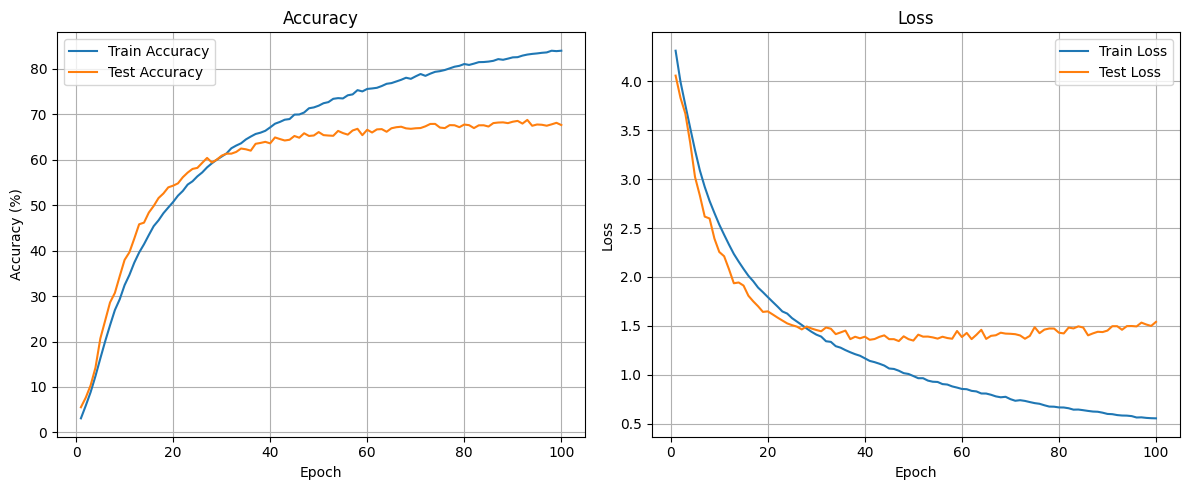

In [15]:
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)

class SimpleGCNLayer(nn.Module):
    def __init__(self,in_features,out_features):
        super(SimpleGCNLayer,self).__init__()
        self.linear=nn.Linear(in_features,out_features)
    def forward(self,x):
        A=torch.eye(x.size(1),device=x.device)
        A_hat=A+torch.eye(x.size(1),device=x.device)
        D_hat=torch.diag(A_hat.sum(1))
        D_hat_inv_sqrt=torch.inverse(torch.sqrt(D_hat))
        norm_A=D_hat_inv_sqrt@A_hat@D_hat_inv_sqrt
        x=torch.matmul(x,norm_A)
        return self.linear(x)

class CNN_GCN_Model(nn.Module):
    def __init__(self):
        super(CNN_GCN_Model,self).__init__()
        self.block1=self._conv_block(3,64)
        self.block2=self._conv_block(64,128)
        self.block3=self._conv_block(128,256)
        self.block4=self._conv_block(256,512)
        self.block5=self._conv_block(512,512)
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(512*1*1,256)
        self.gcn=SimpleGCNLayer(256,128)
        self.dropout=nn.Dropout(0.5)
        self.fc2=nn.Linear(128,100)
    def _conv_block(self,in_c,out_c):
        return nn.Sequential(nn.Conv2d(in_c,out_c,kernel_size=3,padding=1),nn.BatchNorm2d(out_c),nn.ReLU(inplace=True),nn.Conv2d(out_c,out_c,kernel_size=3,padding=1),nn.BatchNorm2d(out_c),nn.ReLU(inplace=True),nn.MaxPool2d(2),nn.Dropout(0.25))
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        x=self.flatten(x)
        x=F.relu(self.fc1(x))
        x=self.gcn(x)
        x=self.dropout(x)
        x=self.fc2(x)
        return x

model=CNN_GCN_Model().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

train_losses_gcn,test_losses_gcn=[],[]
train_accuracies_gcn,test_accuracies_gcn=[],[]

def evaluate():
    model.eval()
    correct,total,loss_total=0,0,0
    with torch.no_grad():
        for images,labels in test_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss_total+=loss.item()*labels.size(0)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
    acc=100*correct/total
    avg_loss=loss_total/total
    test_accuracies_gcn.append(acc)
    test_losses_gcn.append(avg_loss)
    print(f"Test Accuracy: {acc:.2f}%, Test Loss: {avg_loss:.4f}")

def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        correct,total,loss_total=0,0,0
        for images,labels in train_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_total+=loss.item()*labels.size(0)
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()
        train_acc=100*correct/total
        train_loss=loss_total/total
        train_accuracies_gcn.append(train_acc)
        train_losses_gcn.append(train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        evaluate()

train(num_epochs=100)

epochs=range(1,len(train_losses_gcn)+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs,train_accuracies_gcn,label='Train Accuracy')
plt.plot(epochs,test_accuracies_gcn,label='Test Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs,train_losses_gcn,label='Train Loss')
plt.plot(epochs,test_losses_gcn,label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


### CNN + Squeeze Excitation + Residual Connections

Epoch 1/100 | Loss: 2.0875 | Train Acc: 24.21% | Test Acc: 38.95%
Epoch 2/100 | Loss: 1.6095 | Train Acc: 39.99% | Test Acc: 48.66%
Epoch 3/100 | Loss: 1.3350 | Train Acc: 53.25% | Test Acc: 56.17%
Epoch 4/100 | Loss: 1.1664 | Train Acc: 59.76% | Test Acc: 64.99%
Epoch 5/100 | Loss: 1.0510 | Train Acc: 64.18% | Test Acc: 69.45%
Epoch 6/100 | Loss: 0.9609 | Train Acc: 67.94% | Test Acc: 64.80%
Epoch 7/100 | Loss: 0.9043 | Train Acc: 69.81% | Test Acc: 70.54%
Epoch 8/100 | Loss: 0.8571 | Train Acc: 71.73% | Test Acc: 74.92%
Epoch 9/100 | Loss: 0.8344 | Train Acc: 72.62% | Test Acc: 73.48%
Epoch 10/100 | Loss: 0.8072 | Train Acc: 73.68% | Test Acc: 75.84%
Epoch 11/100 | Loss: 0.7752 | Train Acc: 74.72% | Test Acc: 71.89%
Epoch 12/100 | Loss: 0.7766 | Train Acc: 74.65% | Test Acc: 72.88%
Epoch 13/100 | Loss: 0.7509 | Train Acc: 75.70% | Test Acc: 79.20%
Epoch 14/100 | Loss: 0.7353 | Train Acc: 76.24% | Test Acc: 78.46%
Epoch 15/100 | Loss: 0.7287 | Train Acc: 76.14% | Test Acc: 74.92%
Epoc

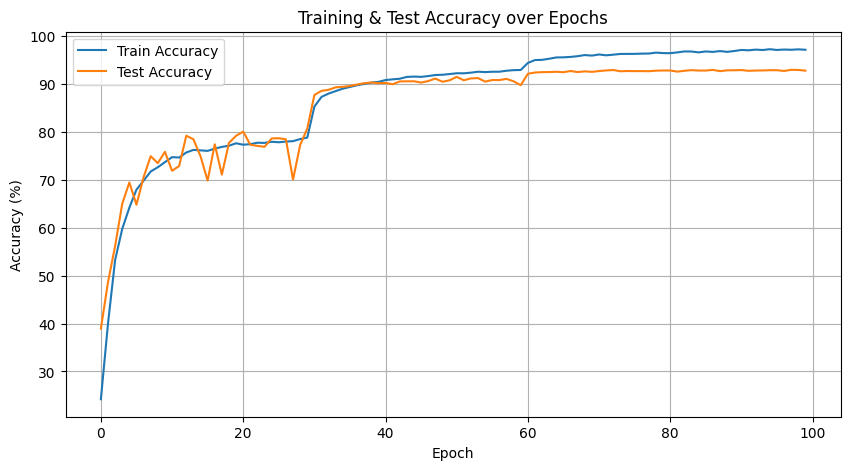

In [16]:
trainloader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
testloader=DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)

class SEBlock(nn.Module):
    def __init__(self,channel,reduction=16):
        super(SEBlock,self).__init__()
        self.fc1=nn.Linear(channel,channel//reduction)
        self.fc2=nn.Linear(channel//reduction,channel)
    def forward(self,x):
        b,c,_ ,_=x.size()
        y=F.adaptive_avg_pool2d(x,1).view(b,c)
        y=F.relu(self.fc1(y))
        y=torch.sigmoid(self.fc2(y)).view(b,c,1,1)
        return x*y

class ResidualSEBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(ResidualSEBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU()
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.se=SEBlock(out_channels)
        self.residual_conv=nn.Conv2d(in_channels,out_channels,kernel_size=1) if in_channels!=out_channels else nn.Identity()
        self.pool=nn.MaxPool2d(2)
        self.dropout=nn.Dropout(0.25)

    def forward(self,x):
        identity=self.residual_conv(x)
        out=self.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        out=self.se(out)
        out+=identity
        out=self.relu(out)
        out=self.pool(out)
        out=self.dropout(out)
        return out

class SE_Residual_CNN(nn.Module):
    def __init__(self):
        super(SE_Residual_CNN,self).__init__()
        self.block1=ResidualSEBlock(3,64)
        self.block2=ResidualSEBlock(64,128)
        self.block3=ResidualSEBlock(128,256)
        self.block4=ResidualSEBlock(256,512)
        self.block5=ResidualSEBlock(512,512)
        self.fc1=nn.Linear(512,512)
        self.dropout=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,100)

    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x)
        x=self.block4(x)
        x=self.block5(x)
        x=F.adaptive_avg_pool2d(x,1).view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        return self.fc2(x)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=SE_Residual_CNN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9,weight_decay=5e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)

train_accuracies_se,test_accuracies_se=[],[]

def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        correct,total,loss_sum=0,0,0
        for x,y in trainloader:
            x,y=x.to(device),y.to(device)
            optimizer.zero_grad()
            out=model(x)
            loss=criterion(out,y)
            loss.backward()
            optimizer.step()
            loss_sum+=loss.item()*x.size(0)
            _,preds=out.max(1)
            correct+=preds.eq(y).sum().item()
            total+=y.size(0)
        train_acc=100.*correct/total
        test_acc=test_model()
        train_accuracies_se.append(train_acc)
        test_accuracies_se.append(test_acc)
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss_sum/total:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

def test_model():
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for x,y in testloader:
            x,y=x.to(device),y.to(device)
            out=model(x)
            _,preds=out.max(1)
            correct+=preds.eq(y).sum().item()
            total+=y.size(0)
    return 100.*correct/total

train_model(num_epochs=100)

plt.figure(figsize=(10,5))
plt.plot(train_accuracies_se,label='Train Accuracy')
plt.plot(test_accuracies_se,label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### CNN + Residual Attention + Attention Modules

Epoch 1/100 | Loss: 2.7908 | Train Acc: 21.87% | Test Acc: 32.11%
Epoch 2/100 | Loss: 1.8004 | Train Acc: 32.43% | Test Acc: 39.68%
Epoch 3/100 | Loss: 1.6321 | Train Acc: 39.79% | Test Acc: 36.59%
Epoch 4/100 | Loss: 1.4983 | Train Acc: 44.63% | Test Acc: 46.82%
Epoch 5/100 | Loss: 1.3595 | Train Acc: 50.34% | Test Acc: 49.58%
Epoch 6/100 | Loss: 1.1988 | Train Acc: 56.54% | Test Acc: 57.56%
Epoch 7/100 | Loss: 1.0457 | Train Acc: 62.60% | Test Acc: 63.62%
Epoch 8/100 | Loss: 0.9283 | Train Acc: 67.32% | Test Acc: 63.59%
Epoch 9/100 | Loss: 0.8474 | Train Acc: 70.17% | Test Acc: 56.68%
Epoch 10/100 | Loss: 0.7771 | Train Acc: 72.97% | Test Acc: 71.30%
Epoch 11/100 | Loss: 0.7247 | Train Acc: 74.73% | Test Acc: 66.08%
Epoch 12/100 | Loss: 0.6811 | Train Acc: 76.55% | Test Acc: 69.63%
Epoch 13/100 | Loss: 0.6467 | Train Acc: 77.56% | Test Acc: 66.65%
Epoch 14/100 | Loss: 0.6206 | Train Acc: 78.62% | Test Acc: 67.10%
Epoch 15/100 | Loss: 0.5939 | Train Acc: 79.58% | Test Acc: 77.95%
Epoc

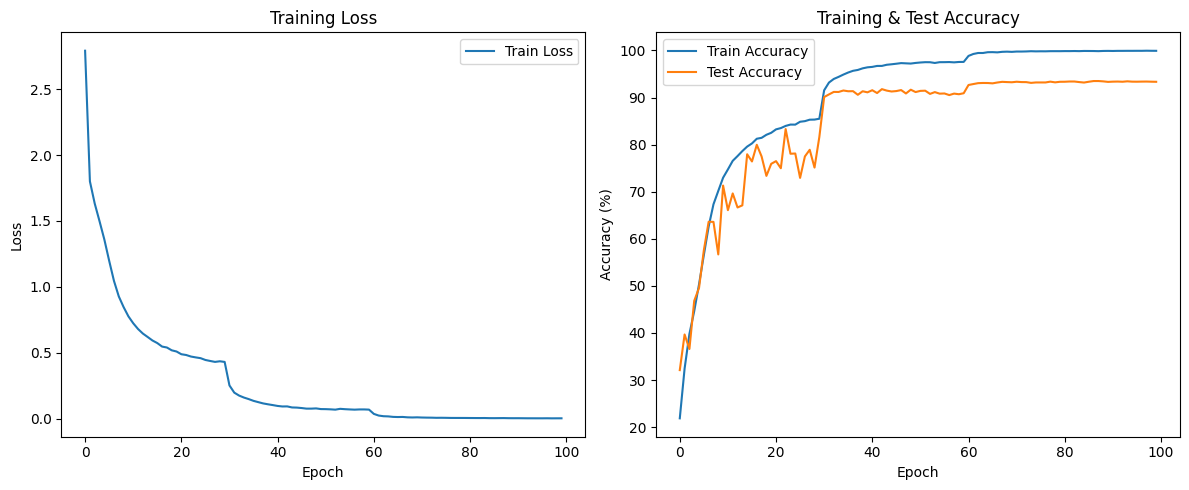

In [17]:
trainloader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)
testloader=DataLoader(testset,batch_size=100,shuffle=False,num_workers=2)

class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super(ResidualBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(out_channels)
        self.relu=nn.ReLU(inplace=True)
        self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(out_channels)
        self.downsample=None
        if stride!=1 or in_channels!=out_channels:
            self.downsample=nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self,x):
        identity=x
        out=self.relu(self.bn1(self.conv1(x)))
        out=self.bn2(self.conv2(out))
        if self.downsample: identity=self.downsample(x)
        out+=identity
        out=self.relu(out)
        return out

class AttentionModule(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(AttentionModule,self).__init__()
        self.trunk_branch=nn.Sequential(
            ResidualBlock(in_channels,out_channels),
            ResidualBlock(out_channels,out_channels)
        )
        self.softmax_branch=nn.Sequential(
            nn.MaxPool2d(3,stride=2,padding=1),
            ResidualBlock(in_channels,out_channels),
            nn.MaxPool2d(3,stride=2,padding=1),
            ResidualBlock(out_channels,out_channels),
            nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True),
            ResidualBlock(out_channels,out_channels),
            nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True),
            nn.Sigmoid()
        )
    def forward(self,x):
        trunk=self.trunk_branch(x)
        mask=self.softmax_branch(x)
        return trunk*mask+trunk

class ResidualAttentionModel(nn.Module):
    def __init__(self):
        super(ResidualAttentionModel,self).__init__()
        self.pre_layers=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.residual_block1=ResidualBlock(64,128,stride=2)
        self.attention_module1=AttentionModule(128,128)
        self.residual_block2=ResidualBlock(128,256,stride=2)
        self.attention_module2=AttentionModule(256,256)
        self.residual_block3=ResidualBlock(256,512,stride=2)
        self.attention_module3=AttentionModule(512,512)
        self.avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512,100)
    def forward(self,x):
        out=self.pre_layers(x)
        out=self.residual_block1(out)
        out=self.attention_module1(out)
        out=self.residual_block2(out)
        out=self.attention_module2(out)
        out=self.residual_block3(out)
        out=self.attention_module3(out)
        out=self.avg_pool(out)
        out=out.view(out.size(0),-1)
        return self.fc(out)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=ResidualAttentionModel().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9,weight_decay=5e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1)
train_losses_atten,train_accuracies_atten,test_accuracies_atten=[],[],[]

def train_model(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        total_loss,correct,total=0.0,0,0
        for inputs,targets in trainloader:
            inputs,targets=inputs.to(device),targets.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,targets)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()*inputs.size(0)
            _,preds=torch.max(outputs,1)
            correct+=preds.eq(targets).sum().item()
            total+=targets.size(0)
        train_acc=100.*correct/total
        test_acc=test_model()
        train_losses_atten.append(total_loss/total)
        train_accuracies_atten.append(train_acc)
        test_accuracies_atten.append(test_acc)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/total:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        scheduler.step()

def test_model():
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for inputs,targets in testloader:
            inputs,targets=inputs.to(device),targets.to(device)
            outputs=model(inputs)
            _,predicted=torch.max(outputs,1)
            correct+=predicted.eq(targets).sum().item()
            total+=targets.size(0)
    return 100.*correct/total

train_model(num_epochs=100)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses_atten,label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies_atten,label='Train Accuracy')
plt.plot(test_accuracies_atten,label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Analysis for CIFAR-100

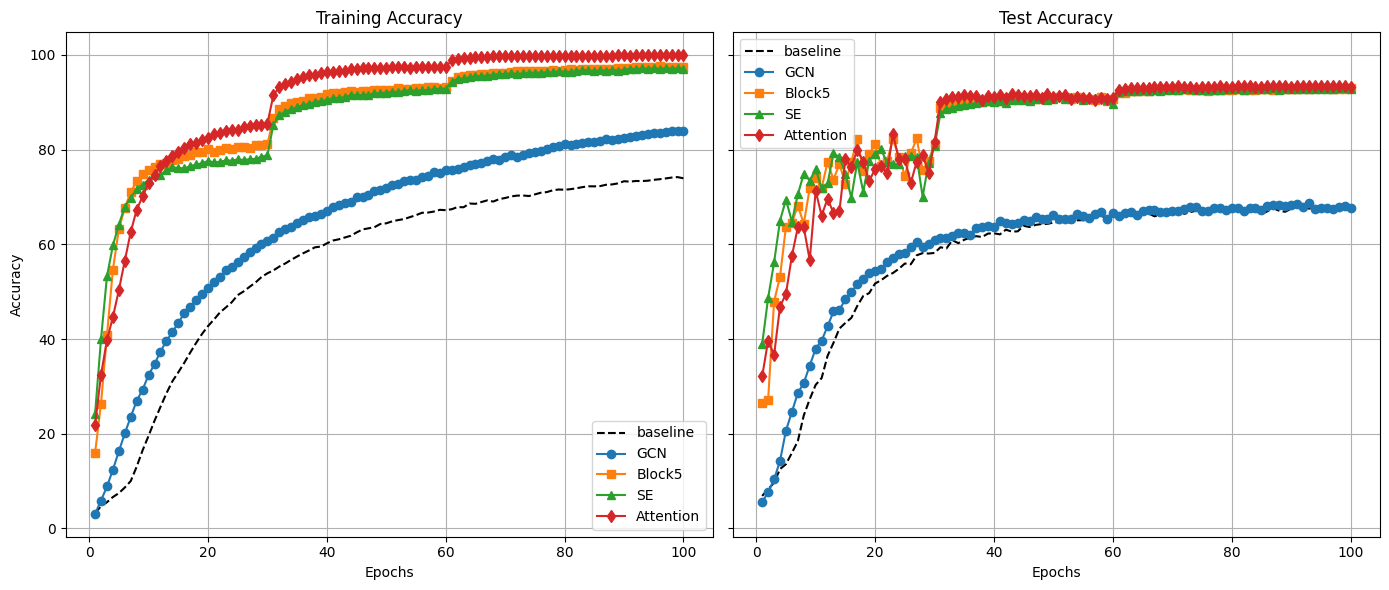

In [20]:
epochs=list(range(1,101))

fig,axes=plt.subplots(1,2,figsize=(14,6),sharey=True)

axes[0].plot(epochs, train_accuracies, label='baseline', linestyle='--', color='black')
axes[0].plot(epochs,train_accuracies_gcn,label='GCN',marker='o')
axes[0].plot(epochs,train_accuracies_5block,label='Block5',marker='s')
axes[0].plot(epochs,train_accuracies_se,label='SE',marker='^')
axes[0].plot(epochs,train_accuracies_atten,label='Attention',marker='d')
axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(epochs,test_accuracies, label='baseline', linestyle='--', color='black')
axes[1].plot(epochs,test_accuracies_gcn,label='GCN',marker='o')
axes[1].plot(epochs,test_accuracies_5block,label='Block5',marker='s')
axes[1].plot(epochs,test_accuracies_se,label='SE',marker='^')
axes[1].plot(epochs,test_accuracies_atten,label='Attention',marker='d')
axes[1].set_title('Test Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


### Thus we can conclude that:
CNN + Residual Attention + Attention Modules performed best but caused overfitting
meanwhile CNN + Squeeze Excitation + Residual Connections performed good and was stable and 5 block approach was also great